### Community Detection in PubMed Heterogeneous Graph

#### Importing required packages

In [1]:
import networkx as nx

#import matplotlib.pyplot as plt

from shutil import copyfile

from array import *

import os

import random

import pandas as pd

#### Reading data from ".dat" file

In [2]:
from scipy.io import loadmat
import numpy as np

In [5]:
arr = loadmat(r"C:\Users\akhil\Downloads\akhil_webui 4\akhil_webui\ACM.mat")

In [ ]:
# APV

In [6]:
arr.keys()

dict_keys(['__header__', '__version__', '__globals__', 'TvsP', 'PvsA', 'PvsV', 'AvsF', 'VvsC', 'PvsL', 'PvsC', 'A', 'C', 'F', 'L', 'P', 'T', 'V', 'PvsT', 'CNormPvsA', 'RNormPvsA', 'CNormPvsC', 'RNormPvsC', 'CNormPvsT', 'RNormPvsT', 'CNormPvsV', 'RNormPvsV', 'CNormVvsC', 'RNormVvsC', 'CNormAvsF', 'RNormAvsF', 'CNormPvsL', 'RNormPvsL', 'stopwords', 'nPvsT', 'nT', 'CNormnPvsT', 'RNormnPvsT', 'nnPvsT', 'nnT', 'CNormnnPvsT', 'RNormnnPvsT', 'PvsP', 'CNormPvsP', 'RNormPvsP'])

In [7]:
PA = arr['PvsA'].todense()
PV = arr['PvsV'].todense()

print("AP dims", PA.shape, "PV dims", PV.shape)
PAr, PAc = PA.shape
PVr ,PVc = PV.shape

AP dims (12499, 17431) PV dims (12499, 196)


In [8]:
import json

# Create an empty dictionary to store the JSON data
json_data = {}

# Create a list to hold authors
authors = []

# Create a list to hold papers
papers = []

# Create a list to hold venues
venues = []
count=0
# Iterate through the authors vs. papers adjacency matrix
for author_index, author_row in enumerate(PA.T):
  author_name = f"Author {author_index + 1}"
  author = {
      "name": author_name,
      "papers": []
  }
  # Iterate through papers associated with the author
  for paper_index, paper_has_relation in enumerate(np.array(author_row)[0]):
      if paper_has_relation:
          paper_name = f"Paper {paper_index + 1}"
          author["papers"].append(paper_name)
          papers.append({
              "name": paper_name,
              "venue": f"Venue {np.where(np.array(PV[paper_index]).squeeze())[0][0]}"
          })

  authors.append(author)

"""
# Add authors, papers, and venues to the JSON data dictionary
json_data["authors"] = authors
json_data["papers"] = papers
json_data["venues"] = list(set(PV[0]))  # Deduplicate venues

# Convert the JSON data to a JSON string
json_str = json.dumps(json_data, indent=2)

# Print the JSON string
print(json_str)

"""


'\n# Add authors, papers, and venues to the JSON data dictionary\njson_data["authors"] = authors\njson_data["papers"] = papers\njson_data["venues"] = list(set(PV[0]))  # Deduplicate venues\n\n# Convert the JSON data to a JSON string\njson_str = json.dumps(json_data, indent=2)\n\n# Print the JSON string\nprint(json_str)\n\n'

'Author 17431'

In [9]:
AV = np.zeros((PAc,PVc))
for i in range(PA.shape[1]):
  for j in np.where(PA[:,i])[0]:
    for k in np.where(PV[j,:])[1]:
      AV[j,k] = 1

In [10]:
print(f"Number of edges in PA: {np.sum(PA)}")
print(f"Number of edges in PV: {np.sum(PV)}")
print(f"Number of edges in AV: {np.sum(AV)}")

Number of edges in PA: 37055.0
Number of edges in PV: 12499.0
Number of edges in AV: 12247.0


### Example triangle

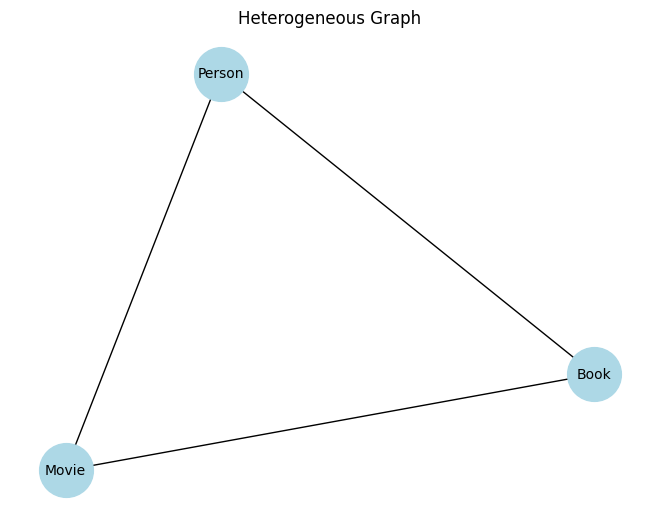

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the heterogeneous graph as shown in the previous example
hetero_graph = nx.Graph()
hetero_graph.add_node('Person', type='Person')
hetero_graph.add_node('Book', type='Book')
hetero_graph.add_node('Movie', type='Movie')
hetero_graph.add_edge('Person', 'Book', relation='Author')
hetero_graph.add_edge('Person', 'Movie', relation='Actor')
hetero_graph.add_edge('Book','Movie', relation='tranlated')

# Plot the graph
pos = nx.spring_layout(hetero_graph)  # Define a layout for the graph
nx.draw(hetero_graph, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=10, font_color='black')

# # Add labels for node types
# labels = {node: node for node in hetero_graph.nodes()}
# nx.draw_networkx_labels(hetero_graph, pos, labels, font_size=8, font_color='black')

# # Add edge labels
# edge_labels = {(u, v): data['relation'] for u, v, data in hetero_graph.edges(data=True)}
# nx.draw_networkx_edge_labels(hetero_graph, pos, edge_labels, font_size=8)

plt.title("Heterogeneous Graph")
plt.show()


## On ACM data graph construction

In [11]:
hetero_graph = nx.Graph()

for author_id in range(AV.shape[0]):
    hetero_graph.add_node(f'Author_{author_id}', type='Author')

for venue in range(AV.shape[1]):
    hetero_graph.add_node(f'Venue_{venue}', type='Venue')

for paper in range(PV.shape[0]):
    hetero_graph.add_node(f'Paper_{paper}', type='Paper')


In [12]:
author = [node for node, data in hetero_graph.nodes(data=True) if data['type'] == 'Author']
venue = [node for node, data in hetero_graph.nodes(data=True) if data['type'] == 'Venue']
paper = [node for node, data in hetero_graph.nodes(data=True) if data['type'] == 'Paper']

In [14]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

client = MongoClient("mongodb://localhost:27017/")

In [17]:
db = client['co_author_data']

In [19]:
collection = db['data']

In [20]:
collection.insert_one({
    "type": "wrote",
    "source_node": "user1",
    "target_node": "article1"
})

InsertOneResult(ObjectId('654c3b85f48d0c8871f2bc30'), acknowledged=True)

In [21]:
count=0
for r in range(AV.shape[0]): #papers_affiliations_matrix.shape[0]):
  for c in np.where(AV[r,:])[0]:
    if f'Author_{r}' in author and f'Venue_{c}' in venue:
      hetero_graph.add_edge(f'Author_{r}',f'Venue_{c}', relation='AV')
      collection.insert_one({ "type": "edge",
    "relation":'AV',
    "source_node": f"Author_{r}",
    "target_node": f'Venue_{c}'})
      collection.insert_one({ "type": "edge",
    "relation":'AV',
    "source_node": f'Venue_{c}',
    "target_node": f"Author_{r}"})
      count+=2

for r in range(PA.shape[0]): #papers_affiliations_matrix.shape[0]):
  for c in np.where(PA[r,:])[1]:
    if f'Paper_{r}' in paper and f'Author_{c}' in author:
      hetero_graph.add_edge(f'Paper_{r}',f'Author_{c}', relation='PA')
      collection.insert_one({ "type": "edge",
    "relation":'PA',
    "source_node": f'Paper_{r}',
    "target_node": f'Author_{c}'})
      collection.insert_one({ "type": "edge",
    "relation":'PA',
    "source_node": f'Author_{c}',
    "target_node": f'Paper_{r}'})
      count+=2

for r in range(PV.shape[0]): #papers_affiliations_matrix.shape[0]):
  for c in np.where(PV[r,:])[1]:
    if f'Paper_{r}' in paper and f'Venue_{c}' in venue:
      hetero_graph.add_edge(f'Paper_{r}',f'Venue_{c}', relation='PV')
      collection.insert_one({ "type": "edge",
    "relation":'PV',
    "source_node": f'Paper_{r}',
    "target_node": f'Venue_{c}'})
      collection.insert_one({ "type": "edge",
    "relation":'PV',
    "source_node": f'Venue_{c}',
    "target_node": f'Paper_{r}'})
      count+=2


In [22]:
color_map = {"Author":'blue', "Venue":"green", "Paper":"red"}

In [23]:
# Extract the node types
node_types = [hetero_graph.nodes[node]["type"] for node in hetero_graph.nodes]

# Use the color mapping to get colors based on node types
node_colors = [color_map[node_type] for node_type in node_types]

In [29]:
all_paths = list(nx.all_simple_paths(hetero_graph, source="Author_0", target="Author_3"))
# Print the result
print(all_paths)


KeyboardInterrupt: 

In [38]:
query = {"source_node": "Author_0", "relation":"PA"}

# Use the find method to retrieve all matching documents
matching_documents = collection.find(query)

In [37]:
for document in matching_documents:
    print(document)

In [39]:
for document in matching_documents: 
    query = {"source_node": f"{document['target_node']}", "relation":"PA"}
    print("query:",query)
    # Use the find method to retrieve all matching documents
    matching_documents1 = collection.find(query)

    for document1 in matching_documents1:
        print(document1)

query: {'source_node': 'Paper_148', 'relation': 'PA'}
{'_id': ObjectId('654c3cbdf48d0c8871f31fe1'), 'type': 'edge', 'relation': 'PA', 'source_node': 'Paper_148', 'target_node': 'Author_0'}
{'_id': ObjectId('654c3cbdf48d0c8871f31fe3'), 'type': 'edge', 'relation': 'PA', 'source_node': 'Paper_148', 'target_node': 'Author_6686'}
{'_id': ObjectId('654c3cbdf48d0c8871f31fe5'), 'type': 'edge', 'relation': 'PA', 'source_node': 'Paper_148', 'target_node': 'Author_11394'}
{'_id': ObjectId('654c3cbdf48d0c8871f31fe7'), 'type': 'edge', 'relation': 'PA', 'source_node': 'Paper_148', 'target_node': 'Author_14555'}
query: {'source_node': 'Paper_3200', 'relation': 'PA'}
{'_id': ObjectId('654c3cc7f48d0c8871f36d49'), 'type': 'edge', 'relation': 'PA', 'source_node': 'Paper_3200', 'target_node': 'Author_0'}
{'_id': ObjectId('654c3cc7f48d0c8871f36d4b'), 'type': 'edge', 'relation': 'PA', 'source_node': 'Paper_3200', 'target_node': 'Author_11394'}
{'_id': ObjectId('654c3cc7f48d0c8871f36d4d'), 'type': 'edge', 'r

In [24]:
#Dont run

for edge in hetero_graph.edges():
  if edge[0] == 'Venue_4':
    print(edge)

('Venue_4', 'Paper_891')
('Venue_4', 'Paper_892')
('Venue_4', 'Paper_893')
('Venue_4', 'Paper_894')
('Venue_4', 'Paper_895')
('Venue_4', 'Paper_896')
('Venue_4', 'Paper_897')
('Venue_4', 'Paper_898')
('Venue_4', 'Paper_899')
('Venue_4', 'Paper_900')
('Venue_4', 'Paper_901')
('Venue_4', 'Paper_902')
('Venue_4', 'Paper_903')
('Venue_4', 'Paper_904')
('Venue_4', 'Paper_905')
('Venue_4', 'Paper_906')
('Venue_4', 'Paper_907')
('Venue_4', 'Paper_908')
('Venue_4', 'Paper_909')
('Venue_4', 'Paper_910')
('Venue_4', 'Paper_911')
('Venue_4', 'Paper_912')
('Venue_4', 'Paper_913')
('Venue_4', 'Paper_914')
('Venue_4', 'Paper_915')
('Venue_4', 'Paper_916')
('Venue_4', 'Paper_917')
('Venue_4', 'Paper_918')
('Venue_4', 'Paper_919')
('Venue_4', 'Paper_920')
('Venue_4', 'Paper_921')
('Venue_4', 'Paper_922')
('Venue_4', 'Paper_923')
('Venue_4', 'Paper_924')
('Venue_4', 'Paper_925')
('Venue_4', 'Paper_926')
('Venue_4', 'Paper_927')
('Venue_4', 'Paper_928')
('Venue_4', 'Paper_929')
('Venue_4', 'Paper_930')


In [ ]:
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.7 MB/s eta 0:00:00


In [ ]:
nt

NameError: ignored

In [ ]:
nt.nodes

[{'color': 'blue',
  'type': 'Author',
  'size': 10,
  'id': 'Author_0',
  'label': 'Author_0',
  'shape': 'dot'},
 {'color': 'green',
  'type': 'Venue',
  'size': 10,
  'id': 'Venue_0',
  'label': 'Venue_0',
  'shape': 'dot'},
 {'color': 'red',
  'type': 'Paper',
  'size': 10,
  'id': 'Paper_148',
  'label': 'Paper_148',
  'shape': 'dot'},
 {'color': 'red',
  'type': 'Paper',
  'size': 10,
  'id': 'Paper_3200',
  'label': 'Paper_3200',
  'shape': 'dot'},
 {'color': 'red',
  'type': 'Paper',
  'size': 10,
  'id': 'Paper_3852',
  'label': 'Paper_3852',
  'shape': 'dot'},
 {'color': 'red',
  'type': 'Paper',
  'size': 10,
  'id': 'Paper_6431',
  'label': 'Paper_6431',
  'shape': 'dot'},
 {'color': 'blue',
  'type': 'Author',
  'size': 10,
  'id': 'Author_1',
  'label': 'Author_1',
  'shape': 'dot'},
 {'color': 'red',
  'type': 'Paper',
  'size': 10,
  'id': 'Paper_680',
  'label': 'Paper_680',
  'shape': 'dot'},
 {'color': 'red',
  'type': 'Paper',
  'size': 10,
  'id': 'Paper_1582',
  '

In [ ]:
from pyvis.network import Network

nt = Network(notebook=True, width='1000px', height='800px')
# populates the nodes and edges data structures
nt.from_nx(hetero_graph)
# Iterate through nodes and set their colors based on the "node_type" attribute
for ix,it in enumerate(nt.nodes):
  nt.nodes[ix]['color']=color_map[it['type']]
nt.show('nx.html')

nx.html


Neighbors code

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

desired_node = "Venue_3"
subgraph = nx.Graph(hetero_graph.subgraph(nx.ego_graph(hetero_graph, desired_node, radius=1)))

# Create a Plotly figure for the subgraph
fig = make_subplots(rows=1, cols=1)
pos = nx.spring_layout(subgraph)
edge_x = []
edge_y = []

for edge in subgraph.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(width=1, color='red'))

node_x = []
node_y = []
node_colors_list = []

for node in subgraph.nodes(data=True):
    x, y = pos[node[0]]
    node_x.append(x)
    node_y.append(y)
    node_colors_list.append("green")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    marker=dict(size=15, line=dict(width=2), color=node_colors_list),
    text=list(subgraph.nodes()))

fig.add_trace(edge_trace)
fig.add_trace(node_trace)

# Customize the layout of the plot
fig.update_layout(
    showlegend=False,
    hovermode='closest',
    title_text=f"Neighbors of Node '{desired_node}'"
)

# Export the figure to an HTML file
fig.write_html(f'neighbors_of_{desired_node}_new.html')

### Finding triangles

In [ ]:
def is_an_edge(ug,u, v):
       for w in list(ug.neighbors(u)):
        if w == v:
            return True
        return False
def find_triangle(ug):
    already_checked_nodes = set()
    triangle_edges = []
    edge_type_combo = []
    for u in nonzero_keys:
        for v in set(ug.neighbors(u)) - already_checked_nodes:
            for w in ug.nodes():
                if is_an_edge(ug,v, w) and is_an_edge(ug,u, w):
                    if u!=v and v!=w and u!=w:
                        triangle_edges.append([u,ug.edges[u,v]["type"],v,ug.edges[v,w]["type"],w,ug.edges[u,w]["type"]])
                        edge_type_combo.append (sorted([ug.edges[u,v]["type"],ug.edges[v,w]["type"],
                                                        ug.edges[u,w]["type"]]))
        already_checked_nodes.add(u)
    #print(triangle_edges)
    return edge_type_combo

In [ ]:
tri_dict = nx.triangles(hetero_graph)

In [ ]:
# Print the number of triangles for each node
for node, triangle_count in tri_dict.items():
  if triangle_count>0:
    print(f"Node {node} participates in {triangle_count} triangles.")

Node Author_27 participates in 2 triangles.
Node Author_130 participates in 2 triangles.
Node Author_195 participates in 1 triangles.
Node Author_208 participates in 2 triangles.
Node Author_239 participates in 1 triangles.
Node Author_243 participates in 1 triangles.
Node Author_257 participates in 1 triangles.
Node Author_272 participates in 1 triangles.
Node Author_366 participates in 1 triangles.
Node Author_499 participates in 1 triangles.
Node Author_517 participates in 1 triangles.
Node Author_569 participates in 2 triangles.
Node Author_584 participates in 2 triangles.
Node Author_607 participates in 1 triangles.
Node Author_617 participates in 1 triangles.
Node Author_644 participates in 1 triangles.
Node Author_688 participates in 1 triangles.
Node Author_711 participates in 1 triangles.
Node Author_732 participates in 1 triangles.
Node Author_741 participates in 1 triangles.
Node Author_749 participates in 1 triangles.
Node Author_786 participates in 1 triangles.
Node Author

In [ ]:
jaccard_similarity = {}
G = hetero_graph
for node in G.nodes():
    neighbors = list(G.neighbors(node))

    for i in range(len(neighbors)):
        for j in range(i + 1, len(neighbors)):
            neighbor1 = neighbors[i]
            neighbor2 = neighbors[j]

            common_neighbors = list(nx.common_neighbors(G, neighbor1, neighbor2))
            triangle_type = G[node][neighbor1]['relation']

            if len(common_neighbors) > 0:
                jaccard_coefficient = len(common_neighbors) / len(set(G.neighbors(node)))

                if triangle_type not in jaccard_similarity:
                    jaccard_similarity[triangle_type] = []

                jaccard_similarity[triangle_type].append(jaccard_coefficient)

# Print the Jaccard similarity for each triangle type
for triangle_type, coefficients in jaccard_similarity.items():
    avg_similarity = sum(coefficients) / len(coefficients)
    print(f"Jaccard similarity for triangle type {triangle_type}: {avg_similarity}")

Jaccard similarity for triangle type AV: 0.008083105380751361
Jaccard similarity for triangle type PA: 0.21565897067064896
Jaccard similarity for triangle type PV: 0.004514790012127089


Jaccard similarity for triangle type AV: 0.008083105380751361
This value indicates that the nodes involved in triangles of type AV have a relatively low degree of overlap in their neighbors. A Jaccard similarity of approximately 0.008 suggests that there are very few common neighbors shared by the nodes in these triangles. It means that the nodes in triangle type AV are not strongly connected or do not share many common connections with each other.

Jaccard similarity for triangle type PA: 0.21565897067064896
In contrast, the Jaccard similarity for triangle type PA is notably higher, approximately 0.216. This suggests that the nodes in triangles of type PA have a more significant degree of overlap in their neighbors. They share a relatively larger number of common neighbors, indicating a stronger level of connection or similarity among the nodes in these triangles.

Jaccard similarity for triangle type PV: 0.004514790012127089
Similar to triangle type AV, the Jaccard similarity for triangle type PV is relatively low (approximately 0.005). This implies that the nodes in triangles of type PV also have a limited degree of overlap in their neighbors. They do not share many common neighbors, suggesting weaker connections or similarity compared to triangle type PA.

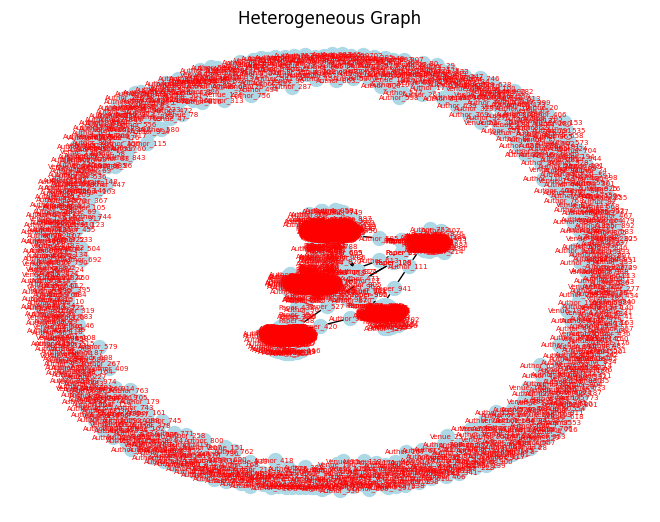

In [ ]:
pos = nx.spring_layout(hetero_graph)  # Define a layout for the graph
nx.draw(hetero_graph, pos, with_labels=True, node_color='lightblue', node_size=100, font_size=5, font_color='red')

plt.title("Heterogeneous Graph")
plt.show()

In [ ]:
from plotly.subplots import make_subplots

desired_node = "Author_1826"
subgraph = nx.Graph(hetero_graph.subgraph(nx.ego_graph(hetero_graph, desired_node, radius=1)))

# Create a Plotly figure for the subgraph
fig = make_subplots(rows=1, cols=1)
pos = nx.spring_layout(subgraph)
edge_x = []
edge_y = []

for edge in subgraph.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(width=1, color='red'))

node_x = []
node_y = []
node_colors_list = []

# for node in subgraph.nodes(data=True):
#     x, y = pos[node[0]]
#     node_x.append(x)
#     node_y.append(y)
#     node_colors_list.append(node_types[node[0]])

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    marker=dict(size=15, line=dict(width=2), color=node_colors_list),
    text=list(subgraph.nodes()))

fig.add_trace(edge_trace)
fig.add_trace(node_trace)

# Customize the layout of the plot
fig.update_layout(
    showlegend=False,
    hovermode='closest',
    title_text=f"Neighbors of Node '{desired_node}'"
)

# Export the figure to an HTML file
fig.write_html(f'neighbors_of_{desired_node}.html')

In [ ]:
for r in range(AV.shape[0]): #papers_affiliations_matrix.shape[0]):
  for c in np.where(AV[r,:]):
    if f'Author_{r}' in author and f'Venue_{c}' in venue:
      hetero_graph.add_edge(f'Author_{r}',f'Venue_{c}', relation='AV')


for r in range(PA.shape[0]): #papers_affiliations_matrix.shape[0]):
  for c in np.where(PA[r,:]):
    hetero_graph.add_edge(f'Paper_{r}',f'Author_{c}', relation='PA')


for r in range(PV.shape[0]): #papers_affiliations_matrix.shape[0]):
  for c in np.where(PV[r,:]):
    hetero_graph.add_edge(f'Paper_{r}',f'Venue_{c}', relation='PV')

In [ ]:
import networkx as nx
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create the heterogeneous graph as shown in previous examples
hetero_graph = nx.Graph()

for author_id in range(AV.shape[0]):
    hetero_graph.add_node(f'Author_{author_id}', type='Author')

for venue in range(AV.shape[1]):
    hetero_graph.add_node(f'Venue_{venue}', type='Venue')

for paper in range(PV.shape[1]):
    hetero_graph.add_node(f'Paper_{paper}', type='Paper')


for r in range(AV.shape[0]): #papers_affiliations_matrix.shape[0]):
  for c in np.where(AV[r,:]):
    hetero_graph.add_edge(f'Author_{r}',f'Venue_{c}', relation='AV')


for r in range(PA.shape[0]): #papers_affiliations_matrix.shape[0]):
  for c in np.where(PA[r,:]):
    hetero_graph.add_edge(f'Paper_{r}',f'Author_{c}', relation='PA')


for r in range(PV.shape[0]): #papers_affiliations_matrix.shape[0]):
  for c in np.where(PV[r,:]):
    hetero_graph.add_edge(f'Paper_{r}',f'Venue_{c}', relation='PV')




# Define colors for each node type
node_colors = {
    'Paper': 'lightblue',
    'Author': 'lightgreen',
    'Venue': 'lightcoral'
}

# Create a Plotly figure for the graph
fig = make_subplots(rows=1, cols=1)
pos = nx.spring_layout(hetero_graph)
edge_x = []
edge_y = []
for edge in hetero_graph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(width=1, color='gray'))

node_x = []
node_y = []
node_colors_list = []
for node in hetero_graph.nodes(data=True):
    x, y = pos[node[0]]
    node_x.append(x)
    node_y.append(y)
    node_type = node[1]['type']
    node_colors_list.append(node_colors[node_type])

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    marker=dict(size=15, line=dict(width=2), color=node_colors_list),
    text=list(hetero_graph.nodes()))

fig.add_trace(edge_trace)
fig.add_trace(node_trace)

# Customize the layout of the plot
fig.update_layout(
    showlegend=False,
    hovermode='closest',
    title_text="Heterogeneous Graph"
)

# Export the figure to an HTML file
fig.write_html('heterogeneous_graph.html')


KeyError: ignored

In [ ]:
arr['RNormPvsT'].todense()[0,:]

matrix([[0.00819672, 0.00819672, 0.00819672, ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
arr['PvsT'].shape

(12499, 1903)

In [ ]:
arr['PvsT'].todense()

matrix([[1., 1., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# P - Publication, A-author, F-Affiliation/University #L - ACM code


In [ ]:
PA = arr['PvsA'].todense() #12499x17431
PL = arr['PvsL'].todense() #12499x73
AF = arr['AvsF'].todense() #17431x1804
AL = np.zeros((17431,73))
for i in range(PL.shape[0]):
  for j in np.where(PA[i,:])[1]:
    for k in np.where(PL[i,:])[1]:
      AL[j,k] = 1

In [ ]:
heterogeneous_graph = nx.Graph()

In [ ]:
for author_id in range(AF.shape[0]): #papers_affiliations_matrix.shape[1]): #Authors
    heterogeneous_graph.add_node(f'Author_{author_id}', type='Author')

for author_id in range(AF.shape[1]): #papers_affiliations_matrix.shape[1]): #Authors
    heterogeneous_graph.add_node(f'Affiliation_{author_id}', type='Affiliation')

for author_id in range(50): #AL.shape[1]): #papers_affiliations_matrix.shape[1]): #Authors
    heterogeneous_graph.add_node(f'code_{author_id}', type='Code')


NameError: ignored

In [ ]:
for r in range(AF.shape[0]): #papers_affiliations_matrix.shape[0]):
  for c in np.where(AF[r])[1]:
    heterogeneous_graph.add_edge(f'Author_{r}',f'Affiliation_{c}', relation='AF')

for r in range(AL.shape[0]): #papers_affiliations_matrix.shape[0]):
  for c in np.where(AL[r])[0]:
    heterogeneous_graph.add_edge(f'Author_{r}',f'code{c}', relation='AL')

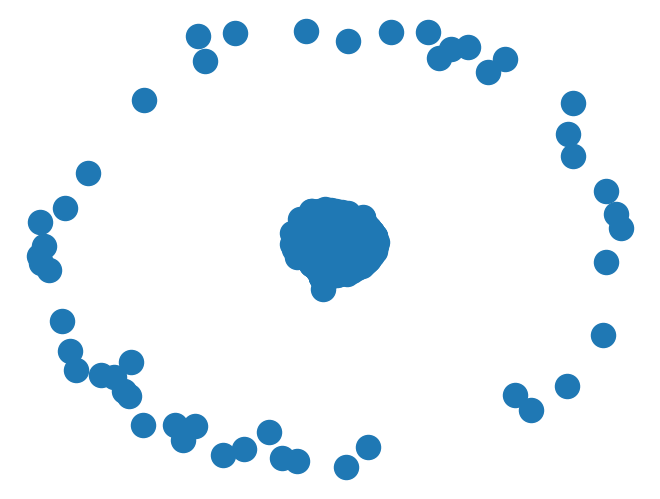

In [ ]:
nx.draw(heterogeneous_graph)

In [ ]:
import re

In [ ]:
pattern = r' ([A-Z])'
for i in range(arr['P'].shape[0]):
  print(re.split(pattern,arr['P'][i][0][0])[0])

Streaming output truncated to the last 5000 lines.
'Temporal collaborative filtering with adaptive neighbourhoods 
'Temporal query substitution for ad search 
'Term-based commercial intent analysis 
'Topic (query) selection for
'Topic prerogative feature selection using multiple query examples for automatic video retrieval 
'Topic set size redux 
'Transforming patents into prior-art queries 
'Two-stage query segmentation for information retrieval 
'Undergraduates evaluations of assigned search topics 
'A unified inverted index for an efficient image and text retrieval 
'Usefulness of click-through data in expert search 
'User-centric multi-criteria information retrieval 
'Users stopping behaviors and estimates of recall 
'Using dynamic markov compression to detect vandalism in the wikipedia 
'Using wikipedia categories for ad hoc search 
'Visualizing the problems with the
'What queries are likely to recur in web search? 
'When is query performance prediction effective? 
'Who said what 

In [ ]:
arr['CNormPvsA'].todense().shape # APC AP (CNormPvsA), PC (CNormPvsC), CA

(12499, 17431)

In [ ]:
arr['A']  # A - Authors

array([[array(['Raluca Paiu'], dtype='<U11')],
       [array(['Panagiotis Karras'], dtype='<U17')],
       [array(['Peter Bumbulis'], dtype='<U14')],
       ...,
       [array(['Zeyu Zheng'], dtype='<U10')],
       [array(['Volker Roth'], dtype='<U11')],
       [array(['Volker Roth'], dtype='<U11')]], dtype=object)

In [ ]:
arr['C'] #-Conference shortform

array([[array(['KDD'], dtype='<U3')],
       [array(['SIGMOD'], dtype='<U6')],
       [array(['WWW'], dtype='<U3')],
       [array(['SIGIR'], dtype='<U5')],
       [array(['CIKM'], dtype='<U4')],
       [array(['SODA'], dtype='<U4')],
       [array(['STOC'], dtype='<U4')],
       [array(['SOSP'], dtype='<U4')],
       [array(['SPAA'], dtype='<U4')],
       [array(['SIGCOMM'], dtype='<U7')],
       [array(['MobiCOMM'], dtype='<U8')],
       [array(['ICML'], dtype='<U4')],
       [array(['COLT'], dtype='<U4')],
       [array(['VLDB'], dtype='<U4')]], dtype=object)

In [ ]:
arr['F'] # University

array([[array(['Ecole Polytechnique'], dtype='<U19')],
       [array(['Aalborg University'], dtype='<U18')],
       [array(['Aarhus University'], dtype='<U17')],
       ...,
       [array(['Ludwig-Maximilians-Universität München'], dtype='<U38')],
       [array(['IBM Watson Research Center'], dtype='<U26')],
       [array(['National Chemical Laboratory'], dtype='<U28')]],
      dtype=object)

In [ ]:
arr['L'] #ACM classification codes

array([[array(['A.0'], dtype='<U3')],
       [array(['A.1'], dtype='<U3')],
       [array(['A.m'], dtype='<U3')],
       [array(['B.2'], dtype='<U3')],
       [array(['B.3'], dtype='<U3')],
       [array(['B.4'], dtype='<U3')],
       [array(['B.5'], dtype='<U3')],
       [array(['B.6'], dtype='<U3')],
       [array(['B.7'], dtype='<U3')],
       [array(['B.8'], dtype='<U3')],
       [array(['C.0'], dtype='<U3')],
       [array(['C.1'], dtype='<U3')],
       [array(['C.2'], dtype='<U3')],
       [array(['C.3'], dtype='<U3')],
       [array(['C.4'], dtype='<U3')],
       [array(['C.5'], dtype='<U3')],
       [array(['C.m'], dtype='<U3')],
       [array(['D.0'], dtype='<U3')],
       [array(['D.1'], dtype='<U3')],
       [array(['D.2'], dtype='<U3')],
       [array(['D.3'], dtype='<U3')],
       [array(['D.4'], dtype='<U3')],
       [array(['D.m'], dtype='<U3')],
       [array(['E.0'], dtype='<U3')],
       [array(['E.1'], dtype='<U3')],
       [array(['E.2'], dtype='<U3')],
       [arra

In [ ]:
arr['P'] #Abstract

array([[array(["'Influence and correlation in social networks  In many online social systems, social ties between users play an important role in dictating their behavior. One of the ways this can happen is through social influence, the phenomenon that the actions of a user can induce his/her friends to behave in a similar way. In systems where social influence exists, ideas, modes of behavior, or new technologies can diffuse through the network like an epidemic. Therefore, identifying and understanding social influence is of tremendous interest from both analysis and design points of view.   This is a difficult task in general, since there are factors such as homophily or unobserved confounding variables that can induce statistical correlation between the actions of friends in a social network. Distinguishing influence from these is essentially the problem of distinguishing correlation from causality, a notoriously hard statistical problem.   In this paper we study this problem system

In [ ]:
arr['T'] #words?

array([[array(['Finally'], dtype='<U7')],
       [array(['In'], dtype='<U2')],
       [array(['One'], dtype='<U3')],
       ...,
       [array(['depth'], dtype='<U5')],
       [array(['polynomial-time'], dtype='<U15')],
       [array(['&#949'], dtype='<U5')]], dtype=object)

In [ ]:
arr['V'] #Conference

array([[array(['Proceeding of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining'],
              dtype='<U97')                                                                                         ],
       [array(['Proceeding of the 17th ACM conference on Information and knowledge management'],
              dtype='<U77')                                                                     ],
       [array(['Proceeding of the 17th international conference on World Wide Web'],
              dtype='<U65')                                                         ],
       [array(['Proceeding of the 18th ACM conference on Information and knowledge management'],
              dtype='<U77')                                                                     ],
       [array(['Proceeding of the 33rd international ACM SIGIR conference on Research and development in information retrieval'],
              dtype='<U110')                                          

In [ ]:
papers_affiliations_matrix = arr['PvsA'].todense()
authors_affiliations_matrix = arr['PvsV'].todense()
# Create a new heterogeneous graph
heterogeneous_graph = nx.Graph()

In [ ]:
for author_id in range(100): #papers_affiliations_matrix.shape[1]): #Authors
    heterogeneous_graph.add_node(f'Author_{author_id}', type='Author')
for r in range(100): #papers_affiliations_matrix.shape[0]):
  for c in np.where(papers_affiliations_matrix[r])[1]:
    heterogeneous_graph.add_edge(f'Paper_{r}',f'Author_{c}', relation='Wrote')

In [ ]:
for paper_id in range(100): #papers_affiliations_matrix.shape[0]): #Papers
    heterogeneous_graph.add_node(f'Paper_{paper_id}', type='Paper')

In [ ]:
for affiliation_id in range(authors_affiliations_matrix.shape[1]): #Conference Name
    heterogeneous_graph.add_node(f'Conference_{affiliation_id}', type='conference')

In [ ]:
for r in range(100): #papers_affiliations_matrix.shape[0]):
  for c in np.where(papers_affiliations_matrix[r])[1]:
    heterogeneous_graph.add_edge(f'Paper_{r}',f'Author_{c}', relation='Wrote')

In [ ]:
for r in range(100): #authors_affiliations_matrix.shape[0]):
  for c in np.where(authors_affiliations_matrix[r])[1]:
    heterogeneous_graph.add_edge(f'Paper_{r}',f'Conference_{c}', relation='Wrote')

In [ ]:
print("Nodes:", len(heterogeneous_graph.nodes(data=True)))
print("Edges:", len(heterogeneous_graph.edges(data=True)))

Nodes: 30126
Edges: 49554


In [ ]:
tri_dict = nx.triangles(heterogeneous_graph)

In [ ]:
arr['P']

NameError: ignored

KeyboardInterrupt: ignored

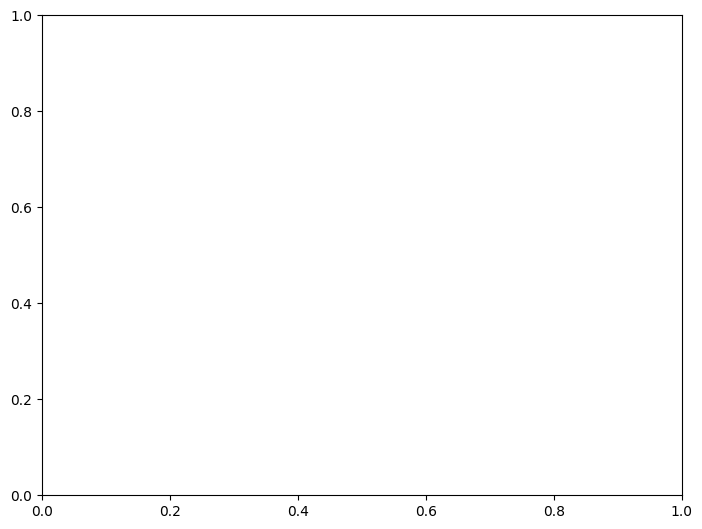

In [ ]:
nx.draw(heterogeneous_graph)

In [ ]:
import networkx as nx
import numpy as np

# Sample matrices (you should replace these with your actual data)
# authors_papers_matrix = np.array()

papers_affiliations_matrix = arr['PvsA'].todense()

authors_affiliations_matrix = arr['AvsF'].todense()
# Create a new heterogeneous graph
heterogeneous_graph = nx.Graph()

# Add nodes and edges for Authors, Papers, and Affiliations
num_authors, num_papers, num_affiliations = authors_papers_matrix.shape[0], papers_affiliations_matrix.shape[1], authors_affiliations_matrix.shape[1]

# Add Author nodes
for author_id in range(num_authors):
    heterogeneous_graph.add_node(f'Author_{author_id}', type='Author')

# Add Paper nodes
for paper_id in range(num_papers):
    heterogeneous_graph.add_node(f'Paper_{paper_id}', type='Paper')

# Add Affiliation nodes
for affiliation_id in range(num_affiliations):
    heterogeneous_graph.add_node(f'Affiliation_{affiliation_id}', type='Affiliation')

# Add edges between Authors and Papers
for author_id in range(num_authors):
    for paper_id in range(num_papers):
        if authors_papers_matrix[author_id][paper_id] == 1:
            heterogeneous_graph.add_edge(f'Author_{author_id}', f'Paper_{paper_id}', relation='Wrote')

# Add edges between Papers and Affiliations
for paper_id in range(num_papers):
    for affiliation_id in range(num_affiliations):
        if papers_affiliations_matrix[paper_id][affiliation_id] == 1:
            heterogeneous_graph.add_edge(f'Paper_{paper_id}', f'Affiliation_{affiliation_id}', relation='Affiliated_With')

# Add edges between Authors and Affiliations
for author_id in range(num_authors):
    for affiliation_id in range(num_affiliations):
        if authors_affiliations_matrix[author_id][affiliation_id] == 1:
            heterogeneous_graph.add_edge(f'Author_{author_id}', f'Affiliation_{affiliation_id}', relation='Affiliated_With')

# Print the nodes and edges of the heterogeneous graph
print("Nodes:", heterogeneous_graph.nodes(data=True))
print("Edges:", heterogeneous_graph.edges(data=True))


TypeError: ignored

In [ ]:


print("Reading link.dat...")
graph = nx.Graph()
graph = nx.read_edgelist(r"/content/drive/MyDrive/PubMed/link.dat", delimiter='\t',
                         create_using=nx.DiGraph(), nodetype=int, data=(('type', int), ('weight', int)))


  # /content/drive/MyDrive/pubmed/link.dat


Reading link.dat...


In [ ]:
graph.is_directed()

True

In [ ]:
#removing self loops from graph
graph.remove_edges_from(nx.selfloop_edges(graph))

In [ ]:
graph.number_of_nodes()

63109

### converting graph to undirected format as triangles() can be applied only on undirected graphs

In [ ]:
ug = graph.to_undirected()

### Getting a subgraph with 100 nodes of original graph to find if it is triangle dense or not.

In [ ]:

#deleting these nodes as they have random strings in attribute1 and 2 columns
nodes_to_be_deleted = [1122,1239,1646,2658,4051,4475,6176,8337,8824,8960,9000,9249,9342,9710,21468,43731,32650,41870,43610]


In [ ]:
len(ug.nodes())

63109

#### Fetching 100 nodes to create subgraph

In [ ]:
node_l = [node for node in ug.nodes() if node not in nodes_to_be_deleted]
node_100 =node_l[:100]

In [ ]:
ug = ug.subgraph(node_100)

In [ ]:
len(ug.nodes())

100

In [ ]:
print(ug.number_of_edges())
print(ug.number_of_nodes())

481
100


In [ ]:
tri_dict = nx.triangles(ug)

### Getting nodes for which the triangle count is atleast 1

In [ ]:
nonzero_keys = [k for k, v in tri_dict.items() if v != 0]
nonzero_keys

['Author_27',
 'Author_130',
 'Author_195',
 'Author_208',
 'Author_239',
 'Author_243',
 'Author_257',
 'Author_272',
 'Author_366',
 'Author_499',
 'Author_517',
 'Author_569',
 'Author_584',
 'Author_607',
 'Author_617',
 'Author_644',
 'Author_688',
 'Author_711',
 'Author_732',
 'Author_741',
 'Author_749',
 'Author_786',
 'Author_803',
 'Author_809',
 'Author_853',
 'Author_887',
 'Author_976',
 'Author_982',
 'Author_1005',
 'Author_1021',
 'Author_1112',
 'Author_1295',
 'Author_1310',
 'Author_1339',
 'Author_1349',
 'Author_1353',
 'Author_1376',
 'Author_1446',
 'Author_1492',
 'Author_1528',
 'Author_1546',
 'Author_1733',
 'Author_1736',
 'Author_1764',
 'Author_1787',
 'Author_1806',
 'Author_1826',
 'Author_1835',
 'Author_1849',
 'Author_1865',
 'Author_1885',
 'Author_2011',
 'Author_2024',
 'Author_2086',
 'Author_2146',
 'Author_2163',
 'Author_2196',
 'Author_2224',
 'Author_2229',
 'Author_2249',
 'Author_2312',
 'Author_2520',
 'Author_2663',
 'Author_2669',
 'Aut

### Counting the number of neighbors of each node

In [ ]:

for x in nonzero_keys:
    counter = 0
    print("Neighbors of",x)
    for n in hetero_graph.neighbors(x):
        print(n)
        counter = counter + 1
    print("Total number of neighbours of",x)
    print(counter)
    print(";")

Streaming output truncated to the last 5000 lines.
Paper_7679
Paper_7680
Paper_7681
Paper_7682
Paper_7683
Paper_7684
Paper_7685
Paper_7686
Paper_7687
Paper_7688
Paper_7689
Paper_7690
Paper_7691
Paper_7692
Paper_7693
Paper_7694
Paper_7695
Paper_7696
Paper_7697
Paper_7698
Paper_7699
Paper_7700
Paper_7701
Paper_7702
Paper_7703
Paper_7704
Paper_7705
Paper_7706
Paper_7707
Paper_7708
Paper_7709
Paper_7710
Paper_7711
Paper_7712
Paper_7713
Paper_7714
Paper_7715
Paper_7716
Paper_7717
Paper_7718
Paper_7719
Paper_7720
Paper_7721
Paper_7722
Paper_7723
Paper_7724
Paper_7725
Paper_7726
Paper_7727
Paper_7728
Paper_7729
Paper_7730
Paper_7731
Paper_7732
Paper_7733
Paper_7734
Paper_7735
Paper_7736
Paper_7737
Paper_7738
Paper_7739
Paper_7740
Paper_7741
Paper_7742
Paper_7743
Paper_7744
Paper_7745
Paper_7746
Paper_7747
Paper_7748
Paper_7749
Paper_7750
Paper_7751
Paper_7752
Paper_7753
Paper_7754
Paper_7755
Paper_7756
Paper_7757
Paper_7758
Paper_7759
Paper_7760
Paper_7761
Paper_7762
Paper_7763
Paper_7764
Pap

### Finding edges that form a triangle

In [ ]:
triangle_edges = []
edge_list = []

In [ ]:
def is_an_edge(ug,u, v):
       for w in list(ug.neighbors(u)):
        if w == v:
            return True
        return False

In [ ]:
def is_an_edge(ug,u, v):
       for w in list(ug.neighbors(u)):
        if w == v:
            return True
        return False
def find_triangle(ug):
    already_checked_nodes = set()
    triangle_edges = []
    edge_type_combo = []
    for u in nonzero_keys:
        for v in set(ug.neighbors(u)) - already_checked_nodes:
            for w in ug.nodes():
                if is_an_edge(ug,v, w) and is_an_edge(ug,u, w):
                    if u!=v and v!=w and u!=w:
                        print(u,v,w)
                        triangle_edges.append([u,ug.edges[u,v]["relation"],v,ug.edges[v,w]["relation"],w,ug.edges[u,w]["relation"]])
                        edge_type_combo.append (sorted([ug.edges[u,v]["relation"],ug.edges[v,w]["relation"],
                                                        ug.edges[u,w]["relation"]]))
        already_checked_nodes.add(u)
    #print(triangle_edges)
    return edge_type_combo

In [ ]:
hetero_graph.edges['Venue_38','Paper_3444']["relation"]

'PV'

In [ ]:
 edges_list = find_triangle(hetero_graph)

Venue_38 Paper_3444 Author_3424
Venue_78 Paper_6284 Author_6212


In [ ]:
hetero_graph.get_edge_data('Paper_3444', 'Author_3424')['relation']

'PA'

In [ ]:
edges_list

In [ ]:
is_an_edge(47789,32267)

True

### Counting the occurences of each edge type in a triangle

In [ ]:
from collections import Counter

freq = map(tuple, edges_list)

final_count = Counter(freq)

for i in set(map(tuple, edges_list)):
    print('{} = {}'.format(i, edges_list.count(list(i))))


('AV', 'PA', 'PV') = 2


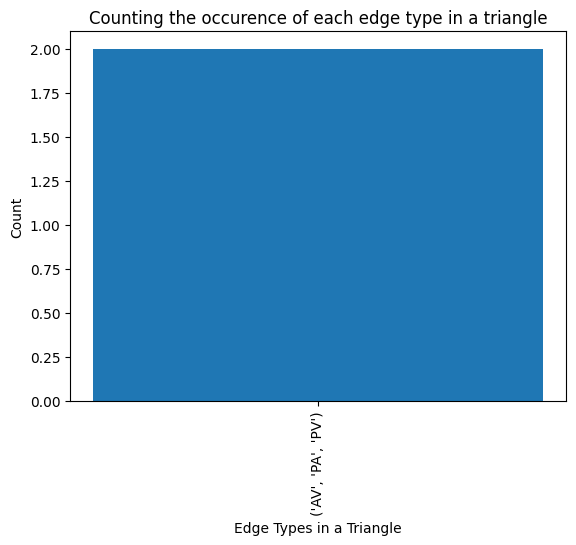

In [ ]:
import matplotlib.pyplot as plt

# getting tuple list and count
counts = [(tuple(i), count) for i, count in final_count.items()]

# Sorrting tuples in descending order
#counts.sort(key=lambda x: x[1], reverse=True)

# Extract the tuples and counts as separate lists
types, count = zip(*counts)

plt.bar(range(len(count)), count)
# Adding labels for each type
plt.xticks(range(len(types)), [str(t) for t in types], rotation=90)
plt.xlabel('Edge Types in a Triangle')
plt.ylabel('Count')
plt.title('Counting the occurence of each edge type in a triangle')
plt.show()


## Metrics for Community Detecetion

### Jaccard Similarity

In [ ]:
import networkx as nx
import csv
import pandas as pd

# Read data from CSV file
data = pd.read_csv(r"/content/drive/MyDrive/pubmed/linkCSV.csv")


df = pd.DataFrame(data, columns=['node1', 'node2', 'edge_type','node1_type','node2_type'] )


# Create a set of node1 and node2 from edges data to fetch nodes with has edge type as 0,2,5,9. These are the edges between 2 same node types.
result_set = set()

# Iterate through each row of the dataframe
for index, row in df.iterrows():
    if ((row['node1'] ,row['node2'] ) in result_set) or ((row['node2'] ,row['node1'] ) in result_set):
        continue
    if row['node1'] in node_100 and row['node2'] in node_100 and row['node1']!=row['node2']:

    # Check if the edge_type is within the given list
        if row['edge_type'] in [0,2,5,9]:

        # Adding nodes to the result set
            result_set.add((row['node1'],row['node2']))




In [ ]:
#function to return number of triangles an edge(u,v) is involved in
def uv_triangles(u,v):
    #for (u,v) in [(8008,8772)]:
    #for (u,v) in result_set:
    common_neighbors = len(set(ug.neighbors(u)).intersection(set(ug.neighbors(v))))

    return common_neighbors

In [ ]:
#calculating jaccard similarity and aggregated scores
labels = {0:"GENE-and-GENE",1:"GENE-causing-DISEASE",2:"DISEASE-and-DISEASE",3:"CHEMICAL-in-GENE",4:"CHEMICAL-in-DISEASE",
          5:"CHEMICAL-and-CHEMICAL",6:"CHEMICAL-in-SPECIES",7:"SPECIES-with-GENE",8:"SPECIES-with-DISEASE",9:"SPECIES-and-SPECIES"}
JacSim = {}
score = {}
aggregated_scores = {}

#for (u,v) in ug.edges():
for (u,v) in result_set:
#for (u,v) in [(18040,8394)]:
    if (v,u) in aggregated_scores:
        continue
    #for i in [3]:
    sim_score = 0
    for i in range(10):
        u_neighbors = set([n for n in ug.neighbors(u) if ug.get_edge_data(u, n)['type'] == i])
        #getting all similar type neighbors to be processed at once. for eg: getting all type 3 neighbors to count triangles of type 1-1-3/ deg(u) with neighbors of type 3
        v_neighbors = set([n for n in ug.neighbors(v) if ug.get_edge_data(v, n)['type'] == i])

        common_neighbors = u_neighbors.intersection(v_neighbors)

        if len(common_neighbors) > 0:
            #getting traingle and node degrees for a speicific type (i)
            deg_u = len([n for n in u_neighbors])
            deg_v = len([n for n in v_neighbors])
            t_uv = len([n for n in common_neighbors])
            #tot_tri_uv = (tot_tri_uv + t_uv)
            if (deg_u + deg_v - t_uv)!=0:
                #calculates jaccard similarity of u,v,type
                JacSim[(u,v, labels[i])] = round((t_uv) / (deg_u + deg_v - t_uv),5)
                #getting score for each type by dividing the number of triangles of that type with total number of triangles and multiplied by Jacc similarity
                score[(u,v, labels[i])]  = round((t_uv / uv_triangles(u,v))*JacSim[(u,v, labels[i])],5)
                sim_score = score[(u,v, labels[i])]  + sim_score
    aggregated_scores[(u,v)] = round(sim_score,4)



#### Below commented code has been used for testing the metric

In [ ]:
JacSim

In [ ]:
score

In [ ]:
aggregated_scores# 0 if nodes does not share neighbors

In [ ]:
aggregated_scores

### Getting node pairs with top12 and bottom 12 aggregated similarity scores

In [ ]:
sorted_scores= sorted(aggregated_scores.items(), key=lambda x: x[1],reverse=True)
top_12 = [pair for pair in sorted_scores if pair[1] != 0 and pair[1]<1][:12]
bottom_12 = [pair for pair in sorted_scores if pair[1] != 0][-12:]

In [ ]:
top_12

[((18040, 8394), 0.6667),
 ((62334, 56628), 0.6269),
 ((22455, 2498), 0.625),
 ((49214, 56628), 0.5906),
 ((826, 55484), 0.589),
 ((8008, 5357), 0.5757),
 ((27757, 5357), 0.5731),
 ((55365, 22455), 0.5714),
 ((50093, 58380), 0.5654),
 ((14439, 58380), 0.558),
 ((31714, 50093), 0.5545),
 ((19446, 826), 0.5528)]

In [ ]:
#getting (u,v) with top score
top12_edges = []
for i,j, in top_12:
    top12_edges.append(i)
top12_edges

[(18040, 8394),
 (62334, 56628),
 (22455, 2498),
 (49214, 56628),
 (826, 55484),
 (8008, 5357),
 (27757, 5357),
 (55365, 22455),
 (50093, 58380),
 (14439, 58380),
 (31714, 50093),
 (19446, 826)]

In [ ]:
#getting a list of all u's and v's in a list
top12_nodes = []
for u,v in top12_edges:
        top12_nodes.append(u)
        top12_nodes.append(v)
#eliminating duplicate nodes from list
top12_nodes = list (set(top12_nodes))
top12_nodes

[2498,
 31714,
 55365,
 14439,
 8008,
 49214,
 8394,
 58380,
 5357,
 27757,
 50093,
 56628,
 19446,
 22455,
 18040,
 826,
 55484,
 62334]

In [ ]:
bottom_12

[((55365, 30122), 0.1407),
 ((34455, 58380), 0.1399),
 ((37323, 30122), 0.1313),
 ((5879, 30122), 0.1306),
 ((3562, 53458), 0.1291),
 ((47671, 41252), 0.128),
 ((28816, 58380), 0.119),
 ((55365, 3562), 0.1154),
 ((3562, 983), 0.101),
 ((2498, 3562), 0.0842),
 ((37323, 3562), 0.0842),
 ((32267, 7360), 0.0589)]

In [ ]:
#getting (u,v) with top score
bottom12_edges = []
for i,j, in bottom_12:
    bottom12_edges.append(i)
bottom12_edges

[(55365, 30122),
 (34455, 58380),
 (37323, 30122),
 (5879, 30122),
 (3562, 53458),
 (47671, 41252),
 (28816, 58380),
 (55365, 3562),
 (3562, 983),
 (2498, 3562),
 (37323, 3562),
 (32267, 7360)]

In [ ]:
#getting a list of all u's and v's in a list
bottom12_nodes = []
for u,v in bottom12_edges:
    bottom12_nodes.append(u)
    bottom12_nodes.append(v)
#eliminating duplicate nodes from list
bottom12_nodes = list (set(bottom12_nodes))
bottom12_nodes

[7360,
 2498,
 41252,
 55365,
 47671,
 30122,
 37323,
 58380,
 5879,
 3562,
 32267,
 28816,
 53458,
 983,
 34455]

### Funtion to generate graph for Top12 and Bottom12 node pairs based on their similarity scores

In [ ]:
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.5 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import numpy as np
from pyvis.network import Network
def func(node_list, edge_list,k,l):

    # neighbors of all nodes in node_list
    neighbors = []
    for node in node_list:
        neighbors.extend(list(set(ug.neighbors(node))))

    # create a new networkx graph
    G = nx.Graph()

    G.add_edges_from(ug.edges())

    # create a subgraph containing only the nodes in node_list and their edges
    H = G.subgraph(neighbors)

    # create a list of edges with triangular connections that involve edge (u,v)
    triangular_edges = []
    tri_edges_uv = []
    for x, y in H.edges():
        for (u,v) in [(k, l)]:
            if (x, y) == (u, v) or (y, x) == (u, v):
                tri_edges_uv.append((u,v))
                common_neighbors = list(nx.common_neighbors(H, x, y))
                for z in common_neighbors:
                    if H.has_edge(x, z) and H.has_edge(y, z):
                        tri_edges_uv.append((x,z))
                        tri_edges_uv.append((y,z))
    print(len(tri_edges_uv))
    for x, y in H.edges():
        for (u,v) in edge_list:
            if (u,v) not in [(k, l)]:
                if (x, y) == (u, v) or (y, x) == (u, v):
                    triangular_edges.append((u,v))
                    common_neighbors = list(nx.common_neighbors(H, x, y))
                    for z in common_neighbors:
                        if H.has_edge(x, z) and H.has_edge(y, z):
                            triangular_edges.append((x,z))
                            triangular_edges.append((y,z))
    print(len(triangular_edges))
    # create a dictionary of node colors for all nodes in H
    node_color_dict = {}
    color_dict = {}
    color_list = ['orangered',  'saddlebrown', 'olive', 'cyan', 'teal', 'magenta', 'yellow', 'lime', 'dimgrey', 'maroon', 'darkorchid']

    #color_list = ['orangered',  'saddlebrown', 'olive', 'cyan', 'teal', 'magenta', 'yellow', 'lime', 'dimgrey', 'maroon', 'darkorchid']

    for i, (u, v) in enumerate(edge_list):
            color_dict[(u, v)] = color_list[i % len(color_list)]


    for node in H.nodes():
        if node not in node_list:
            node_color_dict[node] = 'blue'
    for (u, v), color in color_dict.items():
        if u not in node_color_dict and v not in node_color_dict :
            node_color_dict[u] = node_color_dict[v] = color
        elif u not in node_color_dict and v in node_color_dict:
            node_color_dict[u] =  node_color_dict[v] = node_color_dict[v]
        else:
            node_color_dict[u] =  node_color_dict[v] = node_color_dict[u]
    # create a dictionary of edge colors
    edge_color_dict = {}
    for (u,v) in H.edges():
        if (u,v) not in triangular_edges and (v,u) not in triangular_edges and (u,v) not in tri_edges_uv and (v,u) not in tri_edges_uv:
            edge_color_dict[(u,v)] = "cornflowerblue"
        elif (u,v) in tri_edges_uv or (v,u) in tri_edges_uv:
            edge_color_dict[(u,v)] =  "red"

        else:
            edge_color_dict[(u,v)] = "lightsalmon"#bisque

    # create a list of node colors and sizes
    node_colors = [node_color_dict[node] for node in H.nodes()]
    node_sizes = [9 if node in node_list else 6 for node in H.nodes()]
    edge_colors = [edge_color_dict[edge] for edge in H.edges()]

    # create a pyvis network
    g = Network(notebook=True, width='1000px', height='800px')

    # add nodes and edges to the pyvis network
    for node, color, size in zip(H.nodes(), node_colors, node_sizes):
        g.add_node(str(node), color=color, size=size)

    for edge, color in zip(H.edges(), edge_colors):
        g.add_edge(str(edge[0]), str(edge[1]), color=color)

    g.toggle_physics(False)
       # set the title of the graph

    return g
    #g.show("top12.html")


In [ ]:
g=func(top12_nodes,top12_edges,62334, 56628)
g.show("Node Pairs with Top12 Similarity Scores.html")

33
265
Node Pairs with Top12 Similarity Scores.html


In [ ]:
g=func(bottom12_nodes,bottom12_edges,32267,7360)
g.show("Node Pairs with Bottom12 Similarity Scores.html")

7
77
Node Pairs with Bottom12 Similarity Scores.html
